In [1]:
import numpy as np 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.applications import VGG16

Using TensorFlow backend.


In [2]:
# create a data generator
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
batch_size = 128
epochs = 150
epochs_to_wait_for_improve = 10
IMG_HEIGHT = 150
IMG_WIDTH = 150
total_train = 1440
total_val = 480

In [4]:
# load and iterate training dataset
train_it = datagen.flow_from_directory('anuka1200/train/', class_mode='binary', batch_size=batch_size, shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
# load and iterate validation dataset
val_it = datagen.flow_from_directory('anuka1200/validation/', class_mode='binary', batch_size=64, 
                                     target_size=(IMG_HEIGHT, IMG_WIDTH))

# load and iterate test dataset
test_it = datagen.flow_from_directory('anuka1200/test/', class_mode='binary', 
                                      batch_size=64, target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 1440 images belonging to 2 classes.
Found 480 images belonging to 2 classes.
Found 480 images belonging to 2 classes.


In [5]:
# confirm the iterator works
batchX, batchy = train_it.next()
print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

Batch shape=(128, 150, 150, 3), min=0.000, max=0.980


In [6]:
# visualize images from batches
sample_training_images, _ = next(train_it)

# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        #print(img.shape)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


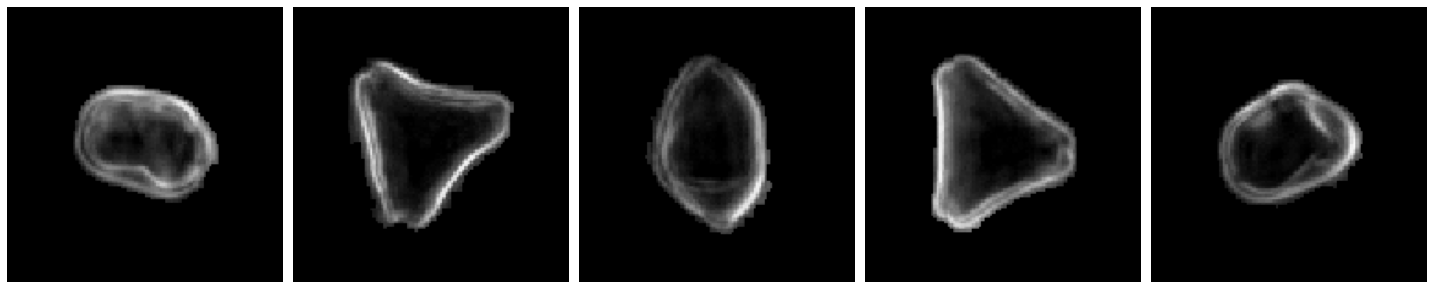

In [7]:
plotImages(sample_training_images[:5])

# Callbacks

In [8]:
class myCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.99):
            print("\nReached 99% accuracy so cancelling training!")
            self.model.stop_training = True

# Instantiate callback
mycallback = myCallback()


early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                        patience=epochs_to_wait_for_improve,
                                                        verbose = 2)

# Modelo 1

In [9]:
# define model
# Create net architecture
modelnet_1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    #keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])


# Compile model
modelnet_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

modelnet_1.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 67500)             0         
_________________________________________________________________
dense (Dense)                (None, 2)                 135002    
Total params: 135,002
Trainable params: 135,002
Non-trainable params: 0
_________________________________________________________________


In [10]:
# fit model
history_1 = modelnet_1.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
)

Epoch 1/150
12/12 [==============================] - 4s 368ms/step - loss: 0.5966 - acc: 0.7507 - val_loss: 0.6535 - val_acc: 0.7333
Epoch 2/150
12/12 [==============================] - 4s 315ms/step - loss: 0.3379 - acc: 0.8722 - val_loss: 0.7110 - val_acc: 0.7792
Epoch 3/150
12/12 [==============================] - 4s 370ms/step - loss: 0.2760 - acc: 0.8875 - val_loss: 0.7003 - val_acc: 0.7896
Epoch 4/150
12/12 [==============================] - 14s 1s/step - loss: 0.2641 - acc: 0.8951 - val_loss: 0.6914 - val_acc: 0.8021
Epoch 5/150
12/12 [==============================] - 5s 451ms/step - loss: 0.2525 - acc: 0.8910 - val_loss: 0.6877 - val_acc: 0.7896
Epoch 6/150
12/12 [==============================] - 4s 323ms/step - loss: 0.2315 - acc: 0.9049 - val_loss: 0.6341 - val_acc: 0.7937
Epoch 7/150
12/12 [==============================] - 3s 256ms/step - loss: 0.2221 - acc: 0.9146 - val_loss: 0.7707 - val_acc: 0.8000
Epoch 8/150
12/12 [==============================] - 3s 249ms/step - lo

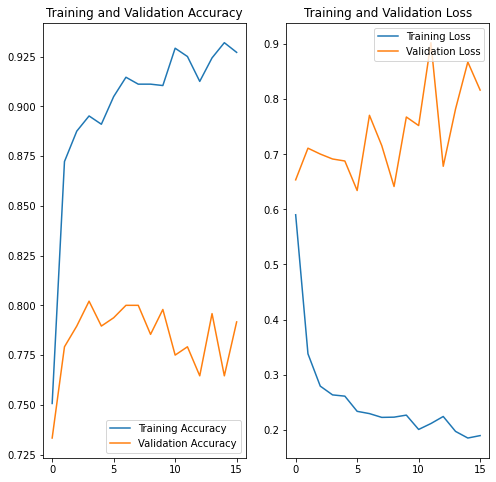

In [11]:
# Visualize training results
acc_1 = history_1.history['acc']
val_acc_1 = history_1.history['val_acc']

loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range_1 = range(len(acc_1))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, acc_1, label='Training Accuracy')
plt.plot(epochs_range_1, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_1, loss_1, label='Training Loss')
plt.plot(epochs_range_1, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [12]:
test_loss_1, test_acc_1 = modelnet_1.evaluate(test_it, verbose=2)

print('\nTest accuracy:', test_acc_1)
print('\nTest loss:', test_loss_1)

# evaluate model
loss_1 = modelnet_1.evaluate_generator(test_it, steps=24)
print(loss_1)

 - 4s - loss: 0.4575 - acc: 0.8250

Test accuracy: 0.825

Test loss: 0.45754703506827354
[0.45754703506827354, 0.825]


# Modelo 2

In [13]:
# define model
# Crear arquitectura de la red 
modelnet_2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    Dense(512, activation='relu'),
    Dense(254, activation='relu'),
    Dense(128, activation='sigmoid'),
    Dense(2, activation='softmax')

])

# Compilar modelo
modelnet_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 67500)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               34560512  
_________________________________________________________________
dense_2 (Dense)              (None, 254)               130302    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32640     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 258       
Total params: 34,723,712
Trainable params: 34,723,712
Non-trainable params: 0
_________________________________________________________________


In [14]:
# fit model
history_2 = modelnet_2.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
)

Epoch 1/150
12/12 [==============================] - 15s 1s/step - loss: 0.6255 - acc: 0.6986 - val_loss: 0.5316 - val_acc: 0.7417
Epoch 2/150
12/12 [==============================] - 17s 1s/step - loss: 0.3535 - acc: 0.8500 - val_loss: 0.5363 - val_acc: 0.7708
Epoch 3/150
12/12 [==============================] - 16s 1s/step - loss: 0.2910 - acc: 0.8882 - val_loss: 0.5538 - val_acc: 0.7750
Epoch 4/150
12/12 [==============================] - 16s 1s/step - loss: 0.2703 - acc: 0.8882 - val_loss: 0.5361 - val_acc: 0.7833
Epoch 5/150
12/12 [==============================] - 16s 1s/step - loss: 0.2331 - acc: 0.9069 - val_loss: 0.5339 - val_acc: 0.7937
Epoch 6/150
12/12 [==============================] - 17s 1s/step - loss: 0.2270 - acc: 0.9090 - val_loss: 0.6103 - val_acc: 0.7958
Epoch 7/150
12/12 [==============================] - 16s 1s/step - loss: 0.2514 - acc: 0.9035 - val_loss: 0.5509 - val_acc: 0.7812
Epoch 8/150
12/12 [==============================] - 16s 1s/step - loss: 0.2044 - a

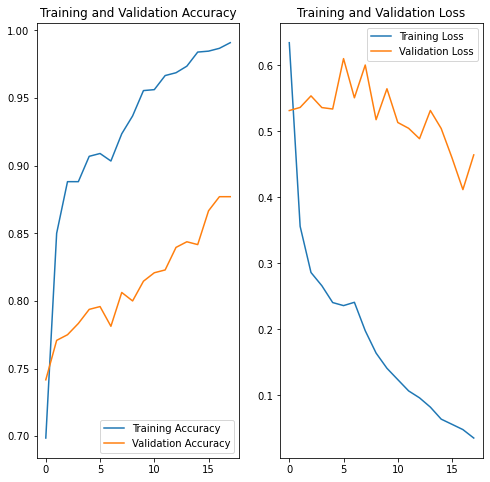

In [15]:
# Visualize training results
acc_2 = history_2.history['acc']
val_acc_2 = history_2.history['val_acc']

loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range_2 = range(len(acc_2))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_2, acc_2, label='Training Accuracy')
plt.plot(epochs_range_2, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_2, loss_2, label='Training Loss')
plt.plot(epochs_range_2, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [16]:
# Accuracy
test_loss_2, test_acc_2 = modelnet_2.evaluate(test_it, verbose=2)

print('\nTest accuracy:', test_acc_2)
print('\nTest loss:', test_loss_2)

# evaluate model
loss_2 = modelnet_2.evaluate_generator(test_it, steps=24)
loss_2

 - 2s - loss: 0.4254 - acc: 0.8729

Test accuracy: 0.87291664

Test loss: 0.42540908232331276


[0.414519339799881, 0.87291664]

# Modelo 3

In [17]:
modelnet_3 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    #MaxPooling2D(),
    #Conv2D(32, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    #Conv2D(64, 3, padding='same', activation='relu'),
    #MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(2, activation='softmax')
])

In [18]:
modelnet_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 16)      448       
_________________________________________________________________
flatten_2 (Flatten)          (None, 360000)            0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               46080128  
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 258       
Total params: 46,080,834
Trainable params: 46,080,834
Non-trainable params: 0
_________________________________________________________________


In [19]:
# Fit the model
history_3 = modelnet_3.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
)


Epoch 1/150
12/12 [==============================] - 42s 3s/step - loss: 1.3191 - acc: 0.7354 - val_loss: 0.7631 - val_acc: 0.7542
Epoch 2/150
12/12 [==============================] - 42s 3s/step - loss: 0.3593 - acc: 0.8583 - val_loss: 0.5090 - val_acc: 0.7521
Epoch 3/150
12/12 [==============================] - 40s 3s/step - loss: 0.2824 - acc: 0.8896 - val_loss: 0.4977 - val_acc: 0.7917
Epoch 4/150
12/12 [==============================] - 40s 3s/step - loss: 0.2355 - acc: 0.9056 - val_loss: 0.5728 - val_acc: 0.7917
Epoch 5/150
12/12 [==============================] - 42s 3s/step - loss: 0.1881 - acc: 0.9243 - val_loss: 0.6153 - val_acc: 0.8042
Epoch 6/150
12/12 [==============================] - 48s 4s/step - loss: 0.1494 - acc: 0.9458 - val_loss: 0.6466 - val_acc: 0.8146
Epoch 7/150
12/12 [==============================] - 43s 4s/step - loss: 0.1331 - acc: 0.9514 - val_loss: 0.4930 - val_acc: 0.7896
Epoch 8/150
12/12 [==============================] - 42s 3s/step - loss: 0.0950 - a

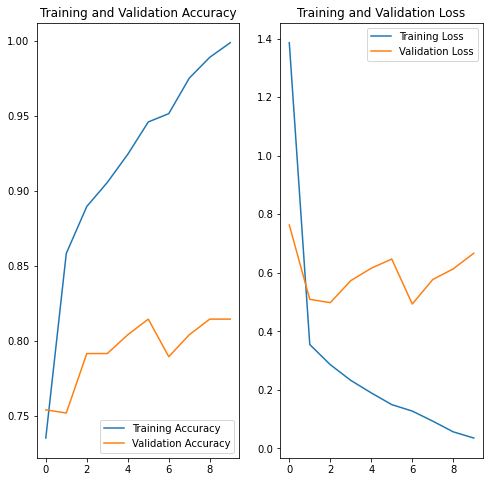

In [20]:
# Visualize training results
acc_3 = history_3.history['acc']
val_acc_3 = history_3.history['val_acc']

loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

epochs_range_3 = range(len(acc_3))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_3, acc_3, label='Training Accuracy')
plt.plot(epochs_range_3, val_acc_3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_3, loss_3, label='Training Loss')
plt.plot(epochs_range_3, val_loss_3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [21]:
test_loss_3, test_acc_3 = modelnet_3.evaluate(test_it, verbose=5)

print('\nTest accuracy:', test_acc_3)
print('\nTest loss:', test_loss_3)


Test accuracy: 0.8541667

Test loss: 0.41922931373119354


In [22]:
# evaluate model
loss_3 = modelnet_3.evaluate_generator(test_it, steps=24)
loss_3

[0.4177629705518484, 0.8541667]

# Modelo 3 mejorado

In [23]:
modelnet_3_enhanced = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.2),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.15),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(2, activation='softmax')
])


modelnet_3_enhanced.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


modelnet_3_enhanced.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 37, 37, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 64)        18496     
___________________________

In [24]:
# Fit the model
history_3_enhanced = modelnet_3_enhanced.fit_generator(
    train_it,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=val_it,
    validation_steps=total_val // batch_size,
    callbacks=[early_stopping_callback, mycallback]
)


Epoch 1/150
12/12 [==============================] - 62s 5s/step - loss: 0.5183 - acc: 0.7479 - val_loss: 0.5160 - val_acc: 0.7625
Epoch 2/150
12/12 [==============================] - 61s 5s/step - loss: 0.3447 - acc: 0.8646 - val_loss: 0.4910 - val_acc: 0.7729
Epoch 3/150
12/12 [==============================] - 57s 5s/step - loss: 0.2872 - acc: 0.8889 - val_loss: 0.5298 - val_acc: 0.7854
Epoch 4/150
12/12 [==============================] - 57s 5s/step - loss: 0.2667 - acc: 0.8958 - val_loss: 0.5429 - val_acc: 0.7875
Epoch 5/150
12/12 [==============================] - 56s 5s/step - loss: 0.2475 - acc: 0.9069 - val_loss: 0.5436 - val_acc: 0.8021
Epoch 6/150
12/12 [==============================] - 59s 5s/step - loss: 0.2079 - acc: 0.9201 - val_loss: 0.5508 - val_acc: 0.7958
Epoch 7/150
12/12 [==============================] - 56s 5s/step - loss: 0.1870 - acc: 0.9271 - val_loss: 0.5286 - val_acc: 0.8104
Epoch 8/150
12/12 [==============================] - 56s 5s/step - loss: 0.1550 - a

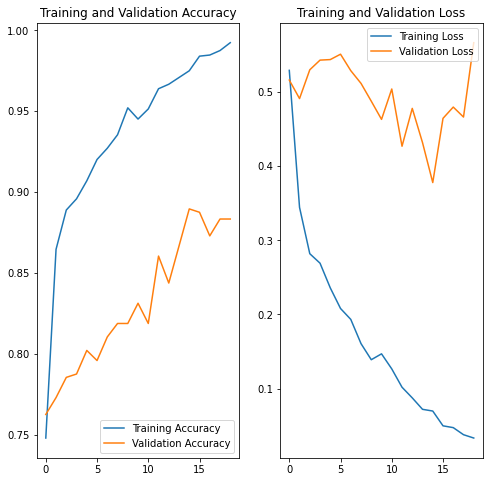

In [25]:
# Visualize training results
acc_3_enhanced = history_3_enhanced.history['acc']
val_acc_3_enhanced = history_3_enhanced.history['val_acc']

loss_3_enhanced = history_3_enhanced.history['loss']
val_loss_3_enhanced = history_3_enhanced.history['val_loss']

epochs_range_3_enhanced = range(len(acc_3_enhanced))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_3_enhanced, acc_3_enhanced, label='Training Accuracy')
plt.plot(epochs_range_3_enhanced, val_acc_3_enhanced, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range_3_enhanced, loss_3_enhanced, label='Training Loss')
plt.plot(epochs_range_3_enhanced, val_loss_3_enhanced, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [26]:
test_loss_3_enhanced, test_acc_3_enhanced = modelnet_3_enhanced.evaluate(test_it, verbose=5)

print('\nTest accuracy:', test_acc_3_enhanced)
print('\nTest loss:', test_loss_3_enhanced)

# evaluate model
loss_3_enhanced = modelnet_3_enhanced.evaluate_generator(test_it, steps=24)
loss_3_enhanced


Test accuracy: 0.8979167

Test loss: 0.3518775375559926


[0.3429104648530483, 0.8979167]

# Training accuracy graph

In [33]:
# Visualize training results
acc_1 = history_1.history['acc']
acc_2 = history_2.history['acc']
acc_3 = history_3.history['acc']
acc_3_enhanced = history_3_enhanced.history['acc']
val_acc_1 = history_1.history['val_acc']
val_acc_2 = history_2.history['val_acc']
val_acc_3 = history_3.history['val_acc']
val_acc_3_enhanced = history_3_enhanced.history['val_acc']

Text(0.5, 1.0, 'Training Accuracy')

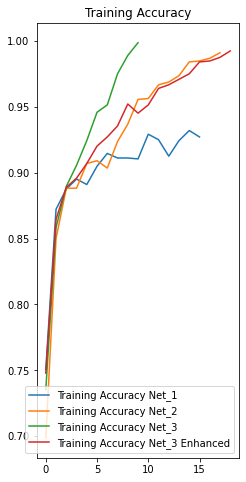

In [35]:
#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, acc_1, label='Training Accuracy Net_1')
plt.plot(epochs_range_2, acc_2, label='Training Accuracy Net_2')
plt.plot(epochs_range_3, acc_3, label='Training Accuracy Net_3')
plt.plot(epochs_range_3_enhanced, acc_3_enhanced, label='Training Accuracy Net_3 Enhanced')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

Text(0.5, 1.0, 'Validation Accuracy')

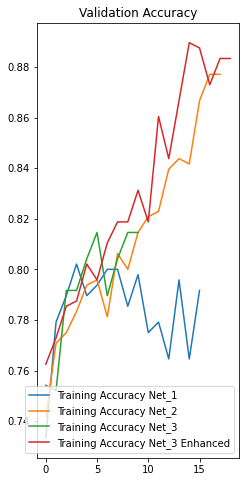

In [36]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, val_acc_1, label='Training Accuracy Net_1')
plt.plot(epochs_range_2, val_acc_2, label='Training Accuracy Net_2')
plt.plot(epochs_range_3, val_acc_3, label='Training Accuracy Net_3')
plt.plot(epochs_range_3_enhanced, val_acc_3_enhanced, label='Training Accuracy Net_3 Enhanced')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')

# Loss

In [37]:
loss_1 = history_1.history['loss']
loss_2 = history_2.history['loss']
loss_3 = history_3.history['loss']
loss_3_enhanced = history_3_enhanced.history['loss']
val_loss_1 = history_1.history['val_loss']
val_loss_2 = history_2.history['val_loss']
val_loss_3 = history_3.history['val_loss']
val_loss_3_enhanced = history_3_enhanced.history['val_loss']

Text(0.5, 1.0, 'Training Accuracy')

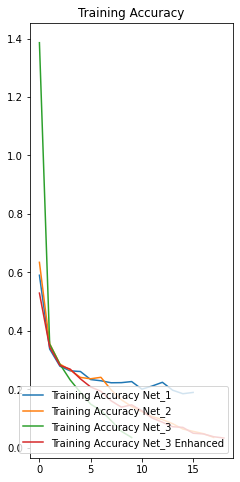

In [38]:
#epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, loss_1, label='Training Accuracy Net_1')
plt.plot(epochs_range_2, loss_2, label='Training Accuracy Net_2')
plt.plot(epochs_range_3, loss_3, label='Training Accuracy Net_3')
plt.plot(epochs_range_3_enhanced, loss_3_enhanced, label='Training Accuracy Net_3 Enhanced')
plt.legend(loc='lower right')
plt.title('Training Accuracy')

Text(0.5, 1.0, 'Validation Accuracy')

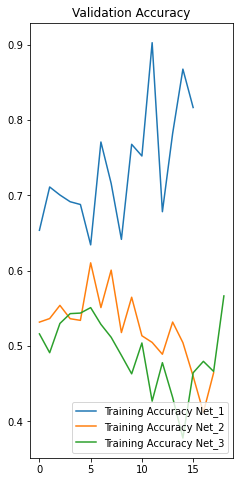

In [39]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range_1, val_loss_1, label='Training Accuracy Net_1')
plt.plot(epochs_range_2, val_loss_2, label='Training Accuracy Net_2')
plt.plot(epochs_range_3_enhanced, val_loss_3_enhanced, label='Training Accuracy Net_3')
plt.legend(loc='lower right')
plt.title('Validation Accuracy')